In [1]:
# Add submodule paths
import sys
import os
sys.path += ['./normalizing_flows', './baselines', './climdex']
# Optionally disable GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import shutil
import os
import climdex.temperature as tdex
import climdex.precipitation as pdex
import logging
import tensorflow_probability as tfp
import seaborn as sns
import experiments.maxt_experiment_base as maxt
import experiments.prcp_experiment_base as prcp
import utils.metrics as metrics
from experiments.common import upsample
from models.glow import build_jflvm
from baselines.dscnn import create_bmd_cnn10
from tensorflow.keras.models import load_model
from normalizing_flows.models import VariationalModel
from regions import southeast_us, pacific_nw
from datasource import EraiRasDataLoader
from utils.data import create_time_series_train_test_generator_v2
from utils.plot import image_map_factory, prcp_cmap
from utils.preprocessing import remove_monthly_means
from utils.distributions import normal, bernoulli_gamma
from tqdm import tqdm

correlation = metrics.correlation_metric()

gcs = gcsfs.GCSFileSystem(project='thesis-research-255223', token='gcs.secret.json')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True).clip(min=0.0, max=np.inf)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True).clip(min=0.0, max=np.inf)
ras_deg116 = xr.open_zarr(data.rasmussen('daily-1-16deg'), consolidated=True)
def get_train_test_splits(data_lo, data_hi, region_fn, scale, cv=False):
    data_lo = region_fn(data_lo)
    data_hi = region_fn(data_hi, scale_factor=scale)
    if cv:
        split_fn = create_time_series_train_test_generator_v2(n_splits=5, test_size=146)
        folds = list(split_fn(data_lo, data_hi))
        return folds
    else:
        lr_train = data_lo.isel(Time=slice(0,data_lo.Time.size-2*365))
        lr_test = data_lo.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
        hr_train = data_hi.isel(Time=slice(0,data_lo.Time.size-2*365))
        hr_test = data_hi.isel(Time=slice(data_lo.Time.size-2*365, data_lo.Time.size+1))
        return lr_train, lr_test, hr_train, hr_test

In [4]:
def plot_random_lr_hr_pairs(data_lr, data_hr, epsilon_prcp=1.0, i=None):
    if i is None:
        i = np.random.randint(0, data_lr.Time.size)
    maxt_lr = data_lr['MAXT'][i]
    maxt_hr = data_hr['MAXT'][i]
    prcp_lr = data_lr['PRCP'][i]
    prcp_hr = data_hr['PRCP'][i]
    fig, axs, plot_fn = image_map_factory(2, 2, figsize=(6,4))
    pmap = prcp_cmap()
    plot_fn(axs[0,0], maxt_lr, maxt_lr.lat, maxt_lr.lon, title='ERA-I, max temperature', cmap='viridis')
    cs = plot_fn(axs[0,1], maxt_hr, maxt_hr.lat, maxt_hr.lon, title='WRF-8, max temperature', cmap='viridis')
    fig.colorbar(cs, ax=axs[0].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('max temperature (K)')
    plot_fn(axs[1,0], prcp_lr, prcp_lr.lat, prcp_lr.lon, title='ERA-I, precipitation', cmap=pmap)
    cs = plot_fn(axs[1,1], prcp_hr, prcp_hr.lat, prcp_hr.lon, title='WRF-8, precipitation', cmap=pmap)
    fig.colorbar(cs, ax=axs[1].ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('precipitation (mm)')
    return fig, i

<xarray.DataArray 'Time' ()>
array('2012-08-19T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    Time     datetime64[ns] 2012-08-19


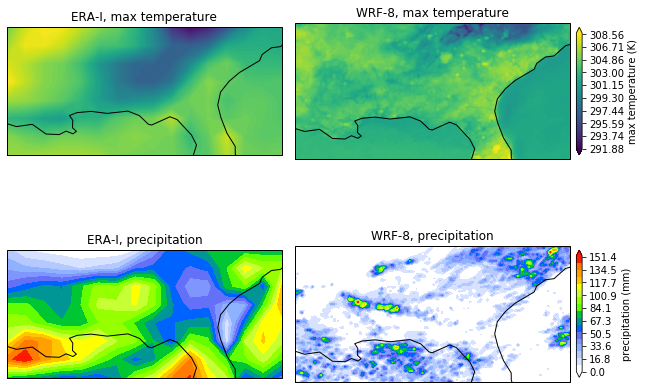

In [5]:
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(erai_deg1, ras_deg18, southeast_us, scale=8)
fig, i = plot_random_lr_hr_pairs(lr_test, hr_test, i=322)
print(hr_test.Time[i])
plt.show()

In [6]:
def metrics_file_uri(experiment_name, run_id, filename='metrics.npz'):
    return f'generative-downscaling-artifact-store/{experiment_name}/{run_id}/artifacts/data/{filename}'

def download_jflvm(run_id, dirname, out_dir, fold=0, epoch=50, ckpt_num=10):
    os.makedirs(out_dir, exist_ok=True)
    filenames = [f'ckpt-{ckpt_num}.index', f'ckpt-{ckpt_num}.data-00000-of-00002', f'ckpt-{ckpt_num}.data-00001-of-00002']
    for filename in filenames:
        with gcs.open(f'gs://generative-downscaling-artifact-store/glow-jflvm-final/{run_id}/artifacts/model/{dirname}/{filename}') as src:
            with open(f'{out_dir}/{filename}', 'wb') as dst:
                shutil.copyfileobj(src, dst)
                
def download_bmd(run_id, out_dir, epoch=50):
    os.makedirs(out_dir, exist_ok=True)
    filename = f'bmd-epoch{epoch}.h5'
    with gcs.open(f'gs://generative-downscaling-artifact-store/bmd-final/{run_id}/artifacts/model/{filename}') as src:
        with open(f'{out_dir}/{filename}', 'wb') as dst:
            shutil.copyfileobj(src, dst)
    return load_model(f'{out_dir}/{filename}')
            
def evaluate_metrics_bmd(fold, model, var='MAXT'):
    """Recomputes metrics for BMD-CNN on the given data fold"""
    if var == 'MAXT':
        data = maxt.preprocess_fold_maxt(fold)
    elif var == 'PRCP':
        data = prcp.preprocess_fold_prcp(fold)
    x_test = data.test[0].astype(np.float32)
    y_test = data.test[1].astype(np.float32)
    y_pred = model.mean(x_test.values)
    y_true = tf.constant(y_test.values)
    if var == 'MAXT':
        indices = tdex.indices('Time', convert_units_fn=lambda x: x+273.15)
        metrics = maxt.eval_metrics(indices, y_true, y_pred, y_test.coords, data.monthly_means[1])
    elif var == 'PRCP':
        indices = pdex.indices('Time')
        tf.debugging.assert_all_finite(y_true, 'y_true has infinite values')
        tf.debugging.assert_all_finite(y_pred, 'y_pred has infinite values')
        y_true, y_pred = tf.where(y_true > 1.0, y_true**3, 0.0), tf.where(y_pred > 1.0, y_pred**3, 0.0)
        metrics = prcp.eval_metrics(indices, y_true, y_pred, y_test.coords)
    return metrics

def evaluate_metrics_jflvm(fold, model, var='MAXT'):
    """Recomputes metrics for Glow-JFLVM (ClimAlign) on the given data fold"""
    if var == 'MAXT':
        data = maxt.preprocess_fold_maxt(fold)
    elif var == 'PRCP':
        data = prcp.preprocess_fold_prcp(fold)
    hr_test = data.test[-1]
    test_ds = data.test_dataset(batch_size=100, buffer_size=1000,
                                map_fn_lo=upsample(hr_test.lat.size, hr_test.lon.size, method='nearest'),
                                mode='test')
    y_true = []
    y_pred = []
    for x, y in test_ds:
        y_ = model.predict_y(x)
        y_pred.append(y_)
        y_true.append(y)
    y_true = tf.concat(y_true, axis=0)
    y_pred = tf.concat(y_pred, axis=0)
    if var == 'MAXT':
        indices = tdex.indices('Time', convert_units_fn=lambda x: x+273.15)
        metrics = maxt.eval_metrics(indices, y_true, y_pred, hr_test.coords, data.monthly_means[1])
    elif var == 'PRCP':
        indices = pdex.indices('Time')
        y_true, y_pred = tf.where(y_true > 1.0, y_true**3, 0.0), tf.where(y_pred > 1.0, y_pred**3, 0.0)
        metrics = prcp.eval_metrics(indices, y_true, y_pred, hr_test.coords)
    return metrics

def compute_metrics_maxt(hr_test, metrics):
    indices = tdex.indices('Time', convert_units_fn=lambda x: x+273.15)
    txx_pred = np.array(metrics['txx'])
    txn_pred = np.array(metrics['txn'])
    txid_pred = np.array(metrics['txid'])
    txsd_pred = np.array(metrics['txsd'])
    maxt_hr_test = hr_test
    txx_true = indices.monthly_txx(maxt_hr_test)
    txn_true = indices.monthly_txn(maxt_hr_test)
    txid_true = indices.annual_icing_days(maxt_hr_test)
    txsd_true = indices.annual_summer_days(maxt_hr_test)
    txx_corr = correlation(txx_true.values, txx_pred).numpy()
    txn_corr = correlation(txn_true.values, txn_pred).numpy()
    txsd_bias = txsd_pred - txsd_true.values
    txid_bias = txid_pred - txid_true.values
    return txx_corr, txn_corr, txsd_bias, txid_bias

def compute_metrics_prcp(hr_test, metrics):
    indices = pdex.indices('Time')
    ar20_pred = metrics['ar20'].astype(np.float64)
    prcptot_pred = metrics['atot'].astype(np.float64)
    cdd_pred = metrics['cdd'].astype(np.float64)
    cwd_pred = metrics['cwd'].astype(np.float64)
    rx1_pred = metrics['mrx1'].astype(np.float64)
    rx5_pred = metrics['mrx5'].astype(np.float64)
    sdii_pred = metrics['sdii'].astype(np.float64)
    prcp_hr_test = hr_test
    ar20_true = indices.annual_r20mm(prcp_hr_test).astype(np.float64)
    prcptot_true = indices.prcptot(prcp_hr_test).astype(np.float64)
    cdd_true = indices.cdd(prcp_hr_test).astype(np.float64)
    cwd_true = indices.cwd(prcp_hr_test).astype(np.float64)
    rx1_true = indices.monthly_rx1day(prcp_hr_test).astype(np.float64)
    rx5_true = indices.monthly_rx5day(prcp_hr_test).astype(np.float64)
    sdii_true = indices.sdii(prcp_hr_test).astype(np.float64)
    ar20_bias = ar20_pred - ar20_true.values
    prcptot_bias = prcptot_pred - prcptot_true.values
    cdd_corr = correlation(cdd_true.values, np.array(cdd_pred)).numpy()
    cwd_corr = correlation(cwd_true.values, np.array(cwd_pred)).numpy()
    rx1_corr = correlation(rx1_true.values, np.array(rx1_pred)).numpy()
    rx5_corr = correlation(rx5_true.values, np.array(rx5_pred)).numpy()
    sdii_corr = correlation(sdii_true.values, np.array(sdii_pred)).numpy()
    return ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr, sdii_corr

def build_spatial_dataframe_maxt(data, model_name=None, region_name=None, lat_size=32, lon_size=64):
    """
    Builds a DataFrame over all folds/metrics with spatial dimensions flattened into a single column.
    """
    # Let xarray and pandas do the hard work of mapping multi-dimensional arrays to a dataframe
    arr = xr.DataArray(data.reshape((data.shape[0], data.shape[1],-1)), dims=('fold','metric','space'),
                       coords={'fold': range(data.shape[0]),
                       'metric': ['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'],
                       'space': range(lat_size*lon_size)})
    arr = arr.mean(dim='fold')
    df = arr.to_dataframe(name='data').reset_index()
    if model_name is not None:
        df['model'] = model_name
    if region_name is not None:
        df['region'] = region_name
    return df

def build_spatial_dataframe_prcp(data, model_name=None, region_name=None, lat_size=32, lon_size=64):
    """
    Builds a DataFrame over all folds/metrics with spatial dimensions flattened into a single column.
    """
    arr = xr.DataArray(data.reshape((data.shape[0], data.shape[1],-1)), dims=('fold','metric','space'),
                       coords={'fold': range(data.shape[0]),
                               'metric': ['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'],
                               'space': range(lat_size*lon_size)})
    arr = arr.mean(dim='fold')
    df = arr.to_dataframe(name='data').reset_index()
    if model_name is not None:
        df['model'] = model_name
    if region_name is not None:
        df['region'] = region_name
    return df

### BCSD

In [7]:
# Southeast-US MAXT
def evaluate_metrics_bcsd_maxt(i, fold, run_id, output_arr):
    uri = metrics_file_uri('bcsd-final', run_id)
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        output_arr[i,:3] = run_metrics['rmse'].squeeze(), run_metrics['bias'].squeeze(), run_metrics['corr'].squeeze()
        txx_corr, txn_corr, txsd_bias, txid_bias = compute_metrics_maxt(hr_test, run_metrics)
        output_arr[i,3:] = txx_corr.squeeze(), txn_corr.squeeze(), np.mean(txsd_bias, axis=0).squeeze(), np.mean(txid_bias, axis=0).squeeze()

In [9]:
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], southeast_us, scale=4, cv=True)
runs = ['9731548836774d7ca3e48530e6278440', '2e93ad143163439e8bfddf0913af176b', '22ddb72d7a5a424d95a775240093345d', '4e24a11413c048659eba4779ea411e36', 'bdeb2e47fffb4760ad33efa18f17f025']
bcsd_maxt_seus = np.zeros((len(runs),7,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    evaluate_metrics_bcsd_maxt(i, fold, run_id, bcsd_maxt_seus)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [8]:
bcsd_maxt_seus_df = pd.DataFrame(bcsd_maxt_seus.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(bcsd_maxt_seus_df.mean(axis=0))
print(bcsd_maxt_seus_df.std(axis=0))

rmse         1.509054
bias        -0.015012
corr         0.926487
txx corr     0.940912
txn corr     0.937963
txsd bias   -1.120264
txid bias    0.001367
dtype: float64
rmse         0.147071
bias         0.206998
corr         0.048411
txx corr     0.047091
txn corr     0.057929
txsd bias    1.979375
txid bias    0.003442
dtype: float64


In [8]:
# single fold test for ClimDEX indices
lr = erai_deg1[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, southeast_us, scale=4)
run_id = '9234c385c667457aa8513efd43ee7059'
bcsd_maxt_seus_2 = np.zeros((1,7,32,64))
evaluate_metrics_bcsd_maxt(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, bcsd_maxt_seus_2)
bcsd_maxt_seus_df_2 = pd.DataFrame(bcsd_maxt_seus_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
bcsd_maxt_seus_df_2.mean(axis=0)

rmse         1.517477
bias        -0.020082
corr         0.972373
txx corr     0.982483
txn corr     0.982544
txsd bias   -1.952962
txid bias    0.006185
dtype: float64

correlation, txx: 0.8876069614251667 txn: 0.84283945368985 txsd: -0.1435546875 txid: 0.0


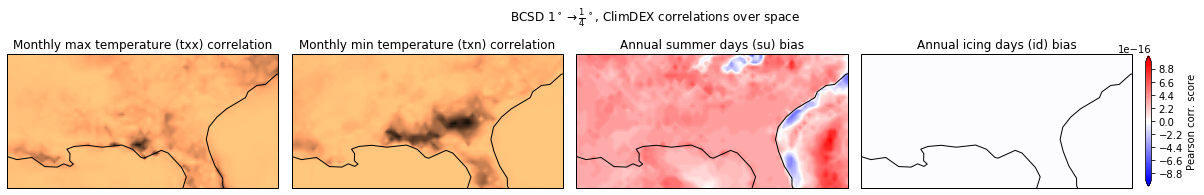

In [10]:
print(f'correlation, txx: {np.mean(txx_corr)} txn: {np.mean(txn_corr)} txsd: {np.mean(txsd_bias)} txid: {np.mean(txid_bias)}')
fig, axs, plot_fn = image_map_factory(1, 4, figsize=(6,4))
plot_fn(axs[0], txx_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly max temperature (txx) correlation', cmap='copper')
plot_fn(axs[1], txn_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly min temperature (txn) correlation', cmap='copper')
plot_fn(axs[2], txsd_bias.squeeze(), hr_test.lat, hr_test.lon, title='Annual summer days (su) bias', cmap='bwr')
cs = plot_fn(axs[3], txid_bias.squeeze(), hr_test.lat, hr_test.lon, title='Annual icing days (id) bias', cmap='bwr')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('Pearson corr. score')
fig.suptitle('BCSD $1^\\circ \\rightarrow \\frac{1}{4}^\\circ$, ClimDEX correlations over space', y=0.9)
plt.show()

In [13]:
# Pacific NW MAXT
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], pacific_nw, scale=4, cv=True)
runs = ['873f30b0b58343afb8db595f2fbe5054', 'ff633ce52a29451c8e8e8b9b41c80e12', '3b0d6ac5f3f34c39b764077e2771e431', '6b0d293560634226aadb0edfbc407f10', '5eb05cc830974ef98ba6901af7b0f0ea']
bcsd_maxt_pnw = np.zeros((len(runs),7,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    evaluate_metrics_bcsd_maxt(i, fold, run_id, bcsd_maxt_pnw)

Computing metrics for fold 1/5
Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [12]:
bcsd_maxt_pnw_df = pd.DataFrame(bcsd_maxt_pnw.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(bcsd_maxt_pnw_df.mean(axis=0))
print(bcsd_maxt_pnw_df.std(axis=0))

rmse         1.543904
bias         0.013486
corr         0.953857
txx corr     0.972053
txn corr     0.978821
txsd bias   -0.165332
txid bias    0.216162
dtype: float64

In [9]:
# single fold test for ClimDEX indices
lr = erai_deg1[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, pacific_nw, scale=4)
run_id = '1a19adff1f8045838e50c3278bc50ae7'
bcsd_maxt_pnw_2 = np.zeros((1,7,32,64))
evaluate_metrics_bcsd_maxt(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, bcsd_maxt_pnw_2)
bcsd_maxt_pnw_df_2 = pd.DataFrame(bcsd_maxt_pnw_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
bcsd_maxt_pnw_df_2.mean(axis=0)

rmse         1.571664
bias         0.021867
corr         0.980450
txx corr     0.983050
txn corr     0.987860
txsd bias   -0.233887
txid bias    0.499512
dtype: float64

In [10]:
# Southeast US PRCP
def evaluate_metrics_bcsd_prcp(i, fold, run_id, output_arr):
    uri = metrics_file_uri('bcsd-final', run_id)
    with gcs.open(uri) as f:
        _, (lr_test, hr_test) = fold
        run_metrics = np.load(f)
        output_arr[i,:3] = run_metrics['rmse'].squeeze(), run_metrics['bias'].squeeze(), run_metrics['corr'].squeeze()
        ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr, sdii_corr = compute_metrics_prcp(hr_test, run_metrics)
        output_arr[i,3:] = np.mean(ar20_bias, axis=0).squeeze(), np.mean(prcptot_bias, axis=0).squeeze(), \
                               cdd_corr.squeeze(), cwd_corr.squeeze(), rx1_corr.squeeze(), rx5_corr.squeeze(), sdii_corr.squeeze()

In [12]:
folds = get_train_test_splits(erai_deg1[['PRCP']], ras_deg14[['PRCP']], southeast_us, scale=4, cv=True)
runs = ['40d1f1d9b97a41a78f904e4dd45b76e0', '7eea7ed77a4d45fab5f19aff0162f50b', '9aab76b880e74358b6ee03515baaddae', 'c8a23641228543d5b5d99df8686a50fe', 'cf032409bb294d17b5e20b2967780de9']
bcsd_prcp_seus = np.zeros((len(runs),10,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    evaluate_metrics_bcsd_prcp(i, fold, run_id, bcsd_prcp_seus)

Computing metrics for fold 1/5


./climdex/climdex/utils.py:66: RuntimeWarning: invalid value encountered in multiply
  chunk_indices = np.where(chunk_cond, all_indices, np.empty(chunk_cond.shape)*np.nan)


Computing metrics for fold 2/5
Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [14]:
bcsd_prcp_seus_df = pd.DataFrame(bcsd_prcp_seus.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])
print(bcsd_prcp_seus_df.mean(axis=0))
print(bcsd_prcp_seus_df.std(axis=0))

rmse            27.319821
bias             0.947283
corr             0.388196
ar20 bias       -0.541992
prcptot bias    44.573774
cdd corr         0.296314
cwd corr         0.126399
rx1 corr         0.135352
rx5 corr         0.165302
sdii corr        0.078302
dtype: float64
rmse              4.973054
bias              1.382197
corr              0.070692
ar20 bias         6.749973
prcptot bias    479.428634
cdd corr          0.313375
cwd corr          0.247611
rx1 corr          0.246390
rx5 corr          0.291046
sdii corr         0.176382
dtype: float64


In [11]:
# single fold test for ClimDEX indices
lr = erai_deg1[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, southeast_us, scale=4)
run_id = '34c08f5e924f476183879dfdb5b57df3'
bcsd_prcp_seus_2 = np.zeros((1,10,32,64))
evaluate_metrics_bcsd_prcp(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, bcsd_prcp_seus_2)
bcsd_prcp_seus_df_2 = pd.DataFrame(bcsd_prcp_seus_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])
bcsd_prcp_seus_df_2.mean(axis=0)

rmse            33.352233
bias             1.158712
corr             0.343903
ar20 bias       -1.074382
prcptot bias    96.119973
cdd corr         0.555601
cwd corr         0.559657
rx1 corr         0.332495
rx5 corr         0.459985
sdii corr        0.315821
dtype: float64

In [16]:
# Pacific NW PRCP
folds = get_train_test_splits(erai_deg1[['PRCP']], ras_deg14[['PRCP']], pacific_nw, scale=4, cv=True)
runs = ['a6c06d7c264645f69b858ae392a77f49', '473f729f5a724b58a8601d52c6a93bbb', 'f45cbc8d6046411ab4521b8a6c68ee94', '8f876b732b3c4de4bce3dd29038447de', '93cce2cd087b4ce98ddd7a6cf146c583']
bcsd_prcp_pnw = np.zeros((len(runs),10,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Computing metrics for fold {i+1}/5')
    evaluate_metrics_bcsd_prcp(i, fold, run_id, bcsd_prcp_pnw)

Computing metrics for fold 1/5
Computing metrics for fold 2/5


./climdex/climdex/utils.py:66: RuntimeWarning: invalid value encountered in multiply
  chunk_indices = np.where(chunk_cond, all_indices, np.empty(chunk_cond.shape)*np.nan)


Computing metrics for fold 3/5
Computing metrics for fold 4/5
Computing metrics for fold 5/5


In [19]:
bcsd_prcp_pnw_df = pd.DataFrame(bcsd_prcp_pnw.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])
print(bcsd_prcp_pnw_df.mean(axis=0))
print(bcsd_prcp_pnw_df.std(axis=0))

rmse             8.898470
bias             0.411170
corr             0.609813
ar20 bias        0.570752
prcptot bias    12.920131
cdd corr         0.410530
cwd corr         0.146859
rx1 corr         0.254612
rx5 corr         0.230308
sdii corr        0.148353
dtype: float64
rmse              2.301895
bias              0.262754
corr              0.060343
ar20 bias         2.362098
prcptot bias    200.935979
cdd corr          0.324227
cwd corr          0.447020
rx1 corr          0.309453
rx5 corr          0.406605
sdii corr         0.352456
dtype: float64


In [12]:
# single fold test for ClimDEX indices
lr = erai_deg1[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, pacific_nw, scale=4)
run_id = '274969ed8108406281c651a67c6b6012'
bcsd_prcp_pnw_2 = np.zeros((1,10,32,64))
evaluate_metrics_bcsd_prcp(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, bcsd_prcp_pnw_2)
bcsd_prcp_pnw_df_2 = pd.DataFrame(bcsd_prcp_pnw_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])
bcsd_prcp_pnw_df_2.mean(axis=0)

rmse             9.677766
bias             0.408816
corr             0.582290
ar20 bias        0.887533
prcptot bias    20.179515
cdd corr         0.801969
cwd corr         0.700769
rx1 corr         0.556909
rx5 corr         0.702349
sdii corr        0.579495
dtype: float64

In [ ]:
print(f'correlation, ar20: {np.mean(ar20_corr)} prcptot: {np.mean(prcptot_corr)} cdd: {np.mean(cdd_corr)} cwd: {np.mean(cwd_corr)}, rx1: {np.mean(rx1_corr)}, rx5: {np.mean(rx5_corr)}')
fig, axs, plot_fn = image_map_factory(2, 3, figsize=(6,4))
plot_fn(axs[0,0], ar20_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual days > 20mm, corr', cmap='copper')
plot_fn(axs[0,1], prcptot_corr.squeeze(), hr_test.lat, hr_test.lon, title='Annual precip total, corr', cmap='copper')
plot_fn(axs[0,2], cdd_corr.squeeze(), hr_test.lat, hr_test.lon, title='Cumulative dry days, corr', cmap='copper')
plot_fn(axs[1,0], cwd_corr.squeeze(), hr_test.lat, hr_test.lon, title='Cumulative wet days, corr', cmap='copper')
cs = plot_fn(axs[1,1], rx1_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly rainfall 1-day, corr', cmap='copper')
cs = plot_fn(axs[1,2], rx5_corr.squeeze(), hr_test.lat, hr_test.lon, title='Monthly rainfall 5-day, corr', cmap='copper')
fig.colorbar(cs, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.6, pad=0.01).set_label('Pearson corr. score')
fig.suptitle('BCSD $1^\\circ \\rightarrow \\frac{1}{4}^\\circ$, ClimDEX correlations over space', y=0.9)
plt.show()

### Bano-Medina CNN-10

In [13]:
# Southeast-US MAXT
def evaluate_metrics_bmd_maxt(i, fold, run_id, output_arr):
    #uri = metrics_file_uri('bmd-final', run_id, filename='metrics-epoch50.npz')
    # due to an evaluation bug, ClimDEX need to be recomputed; precomputed NPZ data files are invalid
    print('Loading model ...')
    encoder = download_bmd(run_id, '/tmp/bmd-model-cv/')
    model = VariationalModel(encoder, normal(), output_shape=(None,ras_deg14.lat.size,ras_deg14.lon.size,1))
#     with gcs.open(uri) as f:
    _, (lr_test, hr_test) = fold
#     run_metrics = np.load(f)
    print('Evaluating metrics ...')
    run_metrics = evaluate_metrics_bmd(fold, model, var='MAXT')
    output_arr[i,:3] = run_metrics['rmse'].squeeze(), run_metrics['bias'].squeeze(), run_metrics['corr'].squeeze()
    txx_corr, txn_corr, txsd_bias, txid_bias = compute_metrics_maxt(hr_test, run_metrics)
    output_arr[i,3:] = txx_corr.squeeze(), txn_corr.squeeze(), np.mean(txsd_bias, axis=0).squeeze(), np.mean(txid_bias, axis=0).squeeze()

In [ ]:
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], southeast_us, scale=4, cv=True)
runs = ['6ecfe2db43894d368c181bbf782cd2f1', '30d5855d3cd544f9a0c97f006fc39cd4', '62189d38922e49f49d6a283d559fd8f3', '0556ad62281547038c3a104fa0583dab', 'c9c0accfbdb14a39aef6632265eafe03']
bmd_seus_maxt = np.zeros((len(runs),7,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Fold {i+1}/5')
    evaluate_metrics_bmd_maxt(i, fold, run_id, bmd_seus_maxt)

In [18]:
bmd_seus_maxt_df = pd.DataFrame(bmd_seus_maxt.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(bmd_seus_maxt_df.mean(axis=0))
print(bmd_seus_maxt_df.std(axis=0))

rmse         1.295184
bias         0.026604
corr         0.904313
txx corr     0.954619
txn corr     0.954463
txsd bias   -0.608740
txid bias   -0.005713
dtype: float64
rmse         0.115766
bias         0.130401
corr         0.046781
txx corr     0.037737
txn corr     0.041632
txsd bias    1.133717
txid bias    0.008569
dtype: float64


In [23]:
nlls = [2.835,2.584,2.46,2.522,2.69]
print(f'{np.mean(nlls)} +/- {np.std(nlls).round(2)}')

2.6182 +/- 0.13


In [14]:
# single fold test for ClimDEX indices
lr = erai_deg1[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, southeast_us, scale=4)
run_id = '6ecfe2db43894d368c181bbf782cd2f1'
bmd_maxt_seus_2 = np.zeros((1,7,32,64))
evaluate_metrics_bmd_maxt(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, bmd_maxt_seus_2)
bmd_maxt_seus_df_2 = pd.DataFrame(bmd_maxt_seus_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
bmd_maxt_seus_df_2.mean(axis=0)

Loading model ...
Evaluating metrics ...


/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


rmse         1.306852
bias         0.010790
corr         0.924779
txx corr     0.988218
txn corr     0.986531
txsd bias   -1.489421
txid bias   -0.018555
dtype: float64

In [ ]:
# Pacific NW MAXT
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], pacific_nw, scale=4, cv=True)
# TODO: rerun last fold
runs = ['8a4d85a7042a48629b13fed3c98f2221', '762187077ba648d1ab5469356d83fd78', 'ecc0eed72f474afaab553c37bcde35a4', '87924b894b854702a9b9763ebce90a5a', '09d58aaac5434aa5a8e56e0893b1793d']
bmd_pnw_maxt = np.zeros((len(runs),7,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Fold {i+1}/5')
    evaluate_metrics_bmd_maxt(fold, run_id, bmd_pnw_maxt)

In [12]:
bmd_pnw_maxt_df = pd.DataFrame(bmd_pnw_maxt.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(bmd_pnw_maxt_df.mean(axis=0))
print(bmd_pnw_maxt_df.std(axis=0))

rmse         1.254230
bias        -0.057463
corr         0.925057
txx corr     0.980160
txn corr     0.984376
txsd bias   -0.205762
txid bias    0.448389
dtype: float64
rmse         0.136107
bias         0.050900
corr         0.020554
txx corr     0.012864
txn corr     0.008085
txsd bias    0.396807
txid bias    0.449698
dtype: float64


In [90]:
nlls = [2.584,2.46,2.522,2.69,2.45]
print(f'{np.mean(nlls)} +/- {np.std(nlls).round(2)}')

2.5412 +/- 0.09


In [15]:
# single fold test for ClimDEX indices
lr = erai_deg1[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, pacific_nw, scale=4)
run_id = '8a4d85a7042a48629b13fed3c98f2221'
bmd_maxt_pnw_2 = np.zeros((1,7,32,64))
evaluate_metrics_bmd_maxt(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, bmd_maxt_pnw_2)
bmd_maxt_pnw_df_2 = pd.DataFrame(bmd_maxt_pnw_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
bmd_maxt_pnw_df_2.mean(axis=0)

Loading model ...
Evaluating metrics ...


rmse         1.265537
bias        -0.102261
corr         0.930731
txx corr     0.989299
txn corr     0.992016
txsd bias   -0.705078
txid bias    1.345540
dtype: float64

In [22]:
# Southeast US PRCP
def evaluate_metrics_bmd_prcp(i, fold, run_id, output_arr):
    #uri = metrics_file_uri('bmd-final', run_id, filename='metrics-epoch50.npz')
    # due to an evaluation bug, ClimDEX need to be recomputed; precomputed NPZ data files are invalid
    print('Loading model ...')
    encoder = download_bmd(run_id, '/tmp/bmd-model-cv/')
    model = VariationalModel(encoder, bernoulli_gamma(), output_shape=(None,ras_deg14.lat.size,ras_deg14.lon.size,1))
#     with gcs.open(uri) as f:
    _, (lr_test, hr_test) = fold
#     run_metrics = np.load(f)
    print('Evaluating metrics ...')
    run_metrics = evaluate_metrics_bmd(fold, model, var='PRCP')
    output_arr[i,:3] = run_metrics['rmse'].squeeze(), run_metrics['bias'].squeeze(), run_metrics['corr'].squeeze()
    ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr, sdii_corr = compute_metrics_prcp(hr_test, run_metrics)
    output_arr[i,3:] = np.mean(ar20_bias, axis=0).squeeze(), np.mean(prcptot_bias, axis=0).squeeze(), \
                                  cdd_corr.squeeze(), cwd_corr.squeeze(), rx1_corr.squeeze(), rx5_corr.squeeze(), sdii_corr.squeeze()

In [ ]:
lr, hr = erai_deg1[['PRCP']], ras_deg14[['PRCP']]
lr, hr = xr.where(lr > 1.0, np.cbrt(lr), 0.0), xr.where(hr > 1.0, np.cbrt(hr), 0.0)
folds = get_train_test_splits(lr, hr, southeast_us, scale=4, cv=True)
runs = ['b22951acf857496eb4d63899479c9797', 'fb38e3d51afd43468f44aa825ba6cd42', 'c9353d690ff04480b5c3b493db62b887', 'ea8f2a388136435b80d6ba2cad2d1a79', '65344dbf0d2e47f5bfca8667df0b8819']
bmd_seus_prcp = np.zeros((len(runs),9,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Fold {i+1}/5')
    evaluate_metrics_bmd_prcp(fold, run_id, bmd_seus_prcp)

In [31]:
bmd_seus_prcp_df = pd.DataFrame(bmd_seus_prcp.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
print(bmd_seus_prcp_df.mean(axis=0))
print(bmd_seus_prcp_df.std(axis=0))

rmse            17.230331
bias            -7.856276
corr             0.506543
ar20 bias        0.499365
prcptot bias    53.927728
cdd corr         0.659649
cwd corr         0.520206
rx1 corr         0.482751
rx5 corr         0.577142
dtype: float64
rmse             2.969383
bias             1.327830
corr             0.092798
ar20 bias        0.169774
prcptot bias    14.976311
cdd corr         0.129027
cwd corr         0.059707
rx1 corr         0.088012
rx5 corr         0.081909
dtype: float64


In [29]:
nlls = [1.913,1.671,1.714,1.721,1.55]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

1.714 +/- 0.12


In [ ]:
# single fold test for ClimDEX indices
lr = erai_deg1[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
lr, hr = xr.where(lr > 1.0, np.cbrt(lr), 0.0), xr.where(hr > 1.0, np.cbrt(hr), 0.0)
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, southeast_us, scale=4)
run_id = 'b22951acf857496eb4d63899479c9797'
bmd_prcp_seus_2 = np.zeros((1,10,32,64))
evaluate_metrics_bmd_prcp(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, bmd_prcp_seus_2)
bmd_prcp_seus_df_2 = pd.DataFrame(bmd_prcp_seus_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])

In [26]:
bmd_prcp_seus_df_2.mean(axis=0)

rmse             18.163506
bias             -7.703475
corr              0.490873
ar20 bias         1.277507
prcptot bias    141.073575
cdd corr          0.581947
cwd corr          0.562654
rx1 corr          0.382920
rx5 corr          0.542040
sdii corr         0.307664
dtype: float64

In [ ]:
# Pacific NW PRCP
lr, hr = erai_deg1[['PRCP']], ras_deg14[['PRCP']]
lr, hr = xr.where(lr > 1.0, np.cbrt(lr), 0.0), xr.where(hr > 1.0, np.cbrt(hr), 0.0)
folds = get_train_test_splits(lr, hr, pacific_nw, scale=4, cv=True)
runs = ['b4e73032c98544e1a9b70f4c68d5eb3b', '8dc60d94af3b457eb506a70ddc0f632d', 'd6179d9b48f64b0eab2f6d0051683bff', 'feb1d3d5cc3546898a84a8f3333be4d2', 'f42546fac4e84e68890028351d0686c2']
bmd_pnw_prcp = np.zeros((len(runs),9,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Fold {i+1}/5')
    evaluate_metrics_bmd_prcp(fold, run_id, bmd_pnw_prcp)

In [36]:
bmd_pnw_prcp_df = pd.DataFrame(bmd_pnw_prcp.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
print(bmd_pnw_prcp_df.mean(axis=0))
print(bmd_pnw_prcp_df.std(axis=0))

rmse              6.424954
bias             -2.773947
corr              0.719796
ar20 bias         1.586328
prcptot bias    140.659997
cdd corr          0.827403
cwd corr          0.737251
rx1 corr          0.743638
rx5 corr          0.814717
dtype: float64
rmse             0.846398
bias             0.628218
corr             0.035359
ar20 bias        0.469979
prcptot bias    43.539647
cdd corr         0.057586
cwd corr         0.099363
rx1 corr         0.100153
rx5 corr         0.069838
dtype: float64


In [32]:
nlls = [1.524,1.46,1.395,1.569,1.518]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

1.493 +/- 0.06


In [ ]:
# single fold test for ClimDEX indices
lr = erai_deg1[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
lr, hr = xr.where(lr > 1.0, np.cbrt(lr), 0.0), xr.where(hr > 1.0, np.cbrt(hr), 0.0)
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, pacific_nw, scale=4)
run_id = 'b4e73032c98544e1a9b70f4c68d5eb3b'
bmd_prcp_pnw_2 = np.zeros((1,10,32,64))
evaluate_metrics_bmd_prcp(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, bmd_prcp_pnw_2)
bmd_prcp_pnw_df_2 = pd.DataFrame(bmd_prcp_pnw_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])

In [27]:
bmd_prcp_pnw_df_2.mean(axis=0)

rmse              6.538834
bias             -2.585642
corr              0.714059
ar20 bias         3.713053
prcptot bias    327.317840
cdd corr          0.790338
cwd corr          0.724557
rx1 corr          0.719556
rx5 corr          0.815110
sdii corr         0.687966
dtype: float64

### JFLVM

In [30]:
# Southeast-US MAXT
def evaluate_metrics_jflvm_maxt(i, fold, run_id, output_arr):
    uri = metrics_file_uri('glow-jflvm-final', run_id, filename=f'metrics-fold{i}-epoch50.npz')
    # due to an evaluation bug, ClimDEX need to be recomputed; precomputed NPZ data files are invalid
    print('Loading model ...')
    _, (lr_test, hr_test) = fold
    download_jflvm(run_id, f'ckpt-fold{i}', '/tmp/jflvm-model-cv/', fold=i, ckpt_num=5)
    model = build_jflvm((None,hr_test.lat.size,hr_test.lon.size,1), scale=4, layers=3, depth=8,
                        min_filters=32, max_filters=256,
                        dnet_layers=3, dnet_filters=64)
    model.load('/tmp/jflvm-model-cv/ckpt', 5)
#     with gcs.open(uri) as f:
#     run_metrics = np.load(f)
    print('Evaluating metrics ...')
    run_metrics = evaluate_metrics_jflvm(fold, model, var='MAXT')
    output_arr[i,:3] = run_metrics['rmse'].squeeze(), run_metrics['bias'].squeeze(), run_metrics['corr'].squeeze()
    txx_corr, txn_corr, txsd_bias, txid_bias = compute_metrics_maxt(hr_test, run_metrics)
    output_arr[i,3:] = txx_corr.squeeze(), txn_corr.squeeze(), np.mean(txsd_bias, axis=0).squeeze(), np.mean(txid_bias, axis=0).squeeze()

In [7]:
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], southeast_us, scale=4, cv=True)
runs = ['da53f9e6df0a48d582b5cf5542026837', '68e50ede16a44ad19fcacd5df5bf9606', '9927867262c3450c876b453eec54e361', 'c269bf3c828140a885c521fc98512904', '9614e60894a841dd917694b2d9de9394']
jflvm_seus_maxt = np.zeros((len(runs),7,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Fold {i+1}/5')
    evaluate_metrics_jflvm_maxt(fold, run_id, jflvm_seus_maxt)

Fold 1/5
Loading model ...


/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


Evaluating metrics ...
Fold 2/5
Loading model ...
Evaluating metrics ...
Fold 3/5
Loading model ...
Evaluating metrics ...
Fold 4/5
Loading model ...
Evaluating metrics ...
Fold 5/5
Loading model ...
Evaluating metrics ...


In [8]:
jflvm_seus_maxt_df = pd.DataFrame(jflvm_seus_maxt.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(jflvm_seus_maxt_df.mean(axis=0))
print(jflvm_seus_maxt_df.std(axis=0))

rmse         1.559211
bias        -0.004684
corr         0.868493
txx corr     0.940612
txn corr     0.935664
txsd bias   -1.214941
txid bias    0.006055
dtype: float64
rmse         0.127266
bias         0.216406
corr         0.063906
txx corr     0.050413
txn corr     0.064778
txsd bias    2.541709
txid bias    0.012302
dtype: float64


In [35]:
nlls = [0.203,0.276,0.138,0.237,0.16]
print(f'{np.mean(nlls)} +/- {np.std(nlls).round(2)}')

0.2028 +/- 0.05


In [31]:
# single fold test for ClimDEX indices
lr = erai_deg1[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, southeast_us, scale=4)
run_id = 'da53f9e6df0a48d582b5cf5542026837'
jflvm_maxt_seus_2 = np.zeros((1,7,32,64))
evaluate_metrics_jflvm_maxt(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, jflvm_maxt_seus_2)
jflvm_maxt_seus_df_2 = pd.DataFrame(jflvm_maxt_seus_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
jflvm_maxt_seus_df_2.mean(axis=0)

Loading model ...
Evaluating metrics ...


rmse         1.600249
bias        -0.040293
corr         0.890680
txx corr     0.980993
txn corr     0.980419
txsd bias   -2.047689
txid bias    0.057943
dtype: float64

In [9]:
# Pacific NW MAXT
folds = get_train_test_splits(erai_deg1[['MAXT']], ras_deg14[['MAXT']], pacific_nw, scale=4, cv=True)
runs = ['cdc0801732f94429ba20a7baecce6e19', 'f43dad3131574ff9b7c25887320c0da8', '2a2f498c04b041228921a5d6dc12d1fe', '1c83e100d57a4f67aa3d58d949f9fb5e', '07894b8a6982479cbd63f8a3faf6df71']
jflvm_pnw_maxt = np.zeros((len(runs),7,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Fold {i+1}/5')
    evaluate_metrics_jflvm_maxt(fold, run_id, jflvm_pnw_maxt)

Fold 1/5
Loading model ...
Evaluating metrics ...
Fold 2/5
Loading model ...
Evaluating metrics ...
Fold 3/5
Loading model ...
Evaluating metrics ...
Fold 4/5
Loading model ...
Evaluating metrics ...
Fold 5/5
Loading model ...
Evaluating metrics ...


In [10]:
jflvm_pnw_maxt_df = pd.DataFrame(jflvm_pnw_maxt.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
print(jflvm_pnw_maxt_df.mean(axis=0))
print(jflvm_pnw_maxt_df.std(axis=0))

rmse         1.581399
bias         0.031982
corr         0.892959
txx corr     0.971980
txn corr     0.978793
txsd bias    0.573730
txid bias    0.066748
dtype: float64
rmse         0.177968
bias         0.145919
corr         0.038212
txx corr     0.021610
txn corr     0.011939
txsd bias    0.548921
txid bias    0.609394
dtype: float64


In [38]:
nlls = [0.537,0.756,0.584,0.702,0.8]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

0.676 +/- 0.1


In [32]:
# single fold test for ClimDEX indices
lr = erai_deg1[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['MAXT']].to_array('chan').transpose('Time','lat','lon','chan')
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, southeast_us, scale=4)
run_id = 'cdc0801732f94429ba20a7baecce6e19'
jflvm_maxt_pnw_2 = np.zeros((1,7,32,64))
evaluate_metrics_jflvm_maxt(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, jflvm_maxt_pnw_2)
jflvm_maxt_pnw_df_2 = pd.DataFrame(jflvm_maxt_pnw_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'txx corr', 'txn corr', 'txsd bias', 'txid bias'])
jflvm_maxt_pnw_df_2.mean(axis=0)

Loading model ...
Evaluating metrics ...


rmse         2.393400
bias        -0.014669
corr         0.854136
txx corr     0.962300
txn corr     0.945772
txsd bias   -1.250000
txid bias    0.113281
dtype: float64

In [35]:
# Southeast US PRCP
def evaluate_metrics_jflvm_prcp(i, fold, run_id, output_arr):
    uri = metrics_file_uri('glow-jflvm-final', run_id, filename=f'metrics-fold{i}-epoch50.npz')
    # due to an evaluation bug, ClimDEX need to be recomputed; precomputed NPZ data files are invalid
    print('Loading model ...')
    _, (lr_test, hr_test) = fold
    download_jflvm(run_id, f'ckpt-fold{i}-epoch50', '/tmp/jflvm-model-cv/', fold=i, ckpt_num=5)
    model = build_jflvm((None,hr_test.lat.size,hr_test.lon.size,1), scale=4, layers=3, depth=4,
                        min_filters=32, max_filters=256,
                        dnet_layers=3, dnet_filters=64)
    model.load('/tmp/jflvm-model-cv/ckpt', 5)
#     with gcs.open(uri) as f:
#     run_metrics = np.load(f)
    print('Evaluating metrics ...')
    run_metrics = evaluate_metrics_jflvm(fold, model, var='PRCP')
    output_arr[i,:3] = run_metrics['rmse'].squeeze(), run_metrics['bias'].squeeze(), run_metrics['corr'].squeeze()
    ar20_bias, prcptot_bias, cdd_corr, cwd_corr, rx1_corr, rx5_corr, sdii_corr = compute_metrics_prcp(hr_test, run_metrics)
    output_arr[i,3:] = np.mean(ar20_bias, axis=0).squeeze(), np.mean(prcptot_bias, axis=0).squeeze(), \
                           cdd_corr.squeeze(), cwd_corr.squeeze(), rx1_corr.squeeze(), rx5_corr.squeeze(), sdii_corr.squeeze()

In [ ]:
lr = prcp.preprocess_dataset(erai_deg1[['PRCP']], (erai_deg1.Time.size, erai_deg1.lat.size, erai_deg1.lon.size))
hr = prcp.preprocess_dataset(ras_deg14[['PRCP']], (ras_deg14.Time.size, ras_deg14.lat.size, ras_deg14.lon.size))
folds = get_train_test_splits(lr, hr, southeast_us, scale=4, cv=True)
runs = ['0ecf1d74228e4a16b748ce1bd3cb2f23', 'dceaad14b70142f9b12366eff26ac70b', 'df0bae41a60347438f55127269e9cec0', '39a9e4f41f52467f924c1274fc5784d7', 'd73a48b2d3544ab4aeb0d86965ce5887']
jflvm_seus_prcp = np.zeros((len(runs),9,32,64))
for i, (run_id, fold) in enumerate(zip(runs, folds)):
    print(f'Fold {i+1}/5')
    evaluate_metrics_jflvm_prcp(fold, run_id, jflvm_seus_prcp)

In [13]:
jflvm_seus_prcp_df = pd.DataFrame(jflvm_seus_prcp.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
print(jflvm_seus_prcp_df.mean(axis=0))
print(jflvm_seus_prcp_df.std(axis=0))

rmse             18.404627
bias              0.081563
corr              0.417987
ar20 bias         8.029150
prcptot bias    408.614459
cdd corr          0.583023
cwd corr          0.470430
rx1 corr          0.458007
rx5 corr          0.573220
dtype: float64
rmse              2.637957
bias              0.862538
corr              0.072647
ar20 bias         4.445230
prcptot bias    239.858688
cdd corr          0.164694
cwd corr          0.075231
rx1 corr          0.089197
rx5 corr          0.050917
dtype: float64
rmse              1.179730
bias              0.385739
corr              0.032489
ar20 bias         1.987967
prcptot bias    107.268066
cdd corr          0.073653
cwd corr          0.033644
rx1 corr          0.039890
rx5 corr          0.022771
dtype: float64


In [41]:
nlls = [0.916,0.539,0.726,0.764,0.499]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

0.689 +/- 0.15


In [ ]:
# single fold test for ClimDEX indices
lr = erai_deg1[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
lr, hr = xr.where(lr > 1.0, np.cbrt(lr), 0.0), xr.where(hr > 1.0, np.cbrt(hr), 0.0)
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, southeast_us, scale=4)
run_id = '10ef348d22624b4d8e5b4fab995bb514'
jflvm_prcp_seus_2 = np.zeros((1,10,32,64))
evaluate_metrics_jflvm_prcp(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, jflvm_prcp_seus_2)
jflvm_prcp_seus_df_2 = pd.DataFrame(jflvm_prcp_seus_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])

In [39]:
jflvm_prcp_seus_df_2.mean(axis=0)

rmse              72.732692
bias               3.830588
corr               0.393957
ar20 bias         15.556803
prcptot bias    1257.442500
cdd corr           0.503628
cwd corr           0.517868
rx1 corr           0.384837
rx5 corr           0.547272
sdii corr          0.319639
dtype: float64

In [ ]:
# Pacific NW PRCP
lr = prcp.preprocess_dataset(erai_deg1[['PRCP']], (erai_deg1.Time.size, erai_deg1.lat.size, erai_deg1.lon.size))
hr = prcp.preprocess_dataset(ras_deg14[['PRCP']], (ras_deg14.Time.size, ras_deg14.lat.size, ras_deg14.lon.size))
folds = get_train_test_splits(lr, hr, pacific_nw, scale=4, cv=True)
runs = ['b9e3dcfab45c476abb43d4dcf3442c99', '98cbfbbc45714fae8cde4e51ec58a414', 'b63a8c08f9a5405aaeee5bbeba9ee191', '56e6e0f0af0140d48966a1c594828628', '5daabf8566344eb893c825271b952c5a']
jflvm_pnw_prcp = np.zeros((len(runs),9,32,64))
for i, (run_id, fold) in enumerate(zip(reversed(runs), folds)):
    print(f'Fold {i+1}/5')
    evaluate_metrics_jflvm_prcp(fold, run_id, jflvm_pnw_prcp)

In [16]:
jflvm_pnw_prcp_df = pd.DataFrame(jflvm_pnw_prcp.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr'])
print(jflvm_pnw_prcp_df.mean(axis=0))
print(jflvm_pnw_prcp_df.std(axis=0))

rmse              7.335016
bias              0.535492
corr              0.669194
ar20 bias         4.200293
prcptot bias    253.057071
cdd corr          0.754928
cwd corr          0.691510
rx1 corr          0.732885
rx5 corr          0.808317
dtype: float64
rmse             0.691139
bias             0.535530
corr             0.031874
ar20 bias        1.459495
prcptot bias    74.701182
cdd corr         0.070167
cwd corr         0.119827
rx1 corr         0.101098
rx5 corr         0.062336
dtype: float64


In [44]:
nlls = [0.473,0.434,0.398,0.442,0.401]
print(f'{np.mean(nlls).round(3)} +/- {np.std(nlls).round(2)}')

0.43 +/- 0.03


In [ ]:
# single fold test for ClimDEX indices
lr = erai_deg1[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
hr = ras_deg14[['PRCP']].to_array('chan').transpose('Time','lat','lon','chan')
lr, hr = xr.where(lr > 1.0, np.cbrt(lr), 0.0), xr.where(hr > 1.0, np.cbrt(hr), 0.0)
lr_train, lr_test, hr_train, hr_test = get_train_test_splits(lr, hr, pacific_nw, scale=4)
run_id = 'e5df4595c4f547d481280122dc96e957'
jflvm_prcp_pnw_2 = np.zeros((1,10,32,64))
evaluate_metrics_jflvm_prcp(0, ((lr_train,hr_train),(lr_test,hr_test)), run_id, jflvm_prcp_pnw_2)
jflvm_prcp_pnw_df_2 = pd.DataFrame(jflvm_prcp_pnw_2.mean(axis=(-1,-2)), columns=['rmse', 'bias', 'corr', 'ar20 bias', 'prcptot bias', 'cdd corr', 'cwd corr', 'rx1 corr', 'rx5 corr', 'sdii corr'])

In [41]:
jflvm_prcp_pnw_df_2.mean(axis=0)

rmse              7.456347
bias              0.761721
corr              0.661684
ar20 bias         9.528646
prcptot bias    661.970003
cdd corr          0.727231
cwd corr          0.627804
rx1 corr          0.699261
rx5 corr          0.787299
sdii corr         0.659863
dtype: float64

### Spatial variance analysis

In [45]:
# Max temperature
bcsd_seus_maxt_spatial_df = build_spatial_dataframe_maxt(bcsd_maxt_seus, model_name='BCSD', region_name='SE-US')
bcsd_pnw_maxt_spatial_df = build_spatial_dataframe_maxt(bcsd_maxt_pnw, model_name='BCSD', region_name='Pacific NW')
bmd_seus_maxt_spatial_df = build_spatial_dataframe_maxt(bmd_seus_maxt, model_name='BMD-CNN', region_name='SE-US')
bmd_pnw_maxt_spatial_df = build_spatial_dataframe_maxt(bmd_pnw_maxt, model_name='BMD-CNN', region_name='Pacific NW')
jflvm_seus_maxt_spatial_df = build_spatial_dataframe_maxt(jflvm_seus_maxt, model_name='ClimAlign', region_name='SE-US')
jfvlm_pnw_maxt_spatial_df = build_spatial_dataframe_maxt(jflvm_pnw_maxt, model_name='ClimAlign', region_name='Pacific NW')
# Precipitation
bcsd_seus_prcp_spatial_df = build_spatial_dataframe_prcp(bcsd_prcp_seus, model_name='BCSD', region_name='SE-US')
bcsd_pnw_prcp_spatial_df = build_spatial_dataframe_prcp(bcsd_prcp_pnw, model_name='BCSD', region_name='Pacific NW')
bmd_seus_prcp_spatial_df = build_spatial_dataframe_prcp(bmd_seus_prcp, model_name='BMD-CNN', region_name='SE-US')
bmd_pnw_prcp_spatial_df = build_spatial_dataframe_prcp(bmd_pnw_prcp, model_name='BMD-CNN', region_name='Pacific NW')
jflvm_seus_prcp_spatial_df = build_spatial_dataframe_prcp(jflvm_seus_prcp, model_name='ClimAlign', region_name='SE-US')
jfvlm_pnw_prcp_spatial_df = build_spatial_dataframe_prcp(jflvm_pnw_prcp, model_name='ClimAlign', region_name='Pacific NW')

In [46]:
from functools import reduce
maxt_dfs = [bcsd_seus_maxt_spatial_df,bcsd_pnw_maxt_spatial_df,bmd_seus_maxt_spatial_df,bmd_pnw_maxt_spatial_df,jflvm_seus_maxt_spatial_df,jfvlm_pnw_maxt_spatial_df]
prcp_dfs = [bcsd_seus_prcp_spatial_df,bcsd_pnw_prcp_spatial_df,bmd_seus_prcp_spatial_df,bmd_pnw_prcp_spatial_df,jflvm_seus_prcp_spatial_df,jfvlm_pnw_prcp_spatial_df]
maxt_all = pd.concat(maxt_dfs, axis=0)
prcp_all = pd.concat(prcp_dfs, axis=0)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


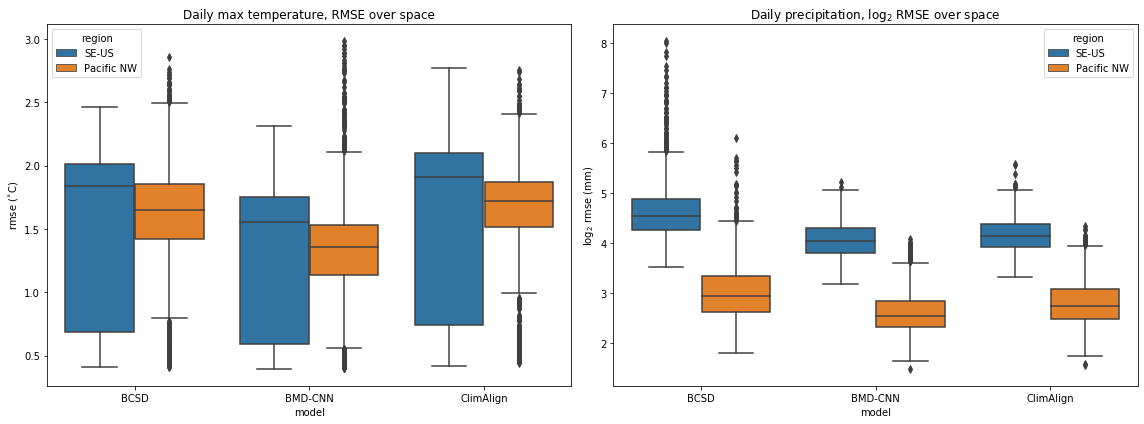

In [91]:
import seaborn as sns
plt.figure(figsize=(2*8,6))
plt.subplot(1,2,1)
sns.boxplot(data=maxt_all[maxt_all['metric']=='rmse'], x='model',y='data',hue='region')
plt.ylabel('rmse ($^{\circ}$C)')
plt.title('Daily max temperature, RMSE over space')
plt.subplot(1,2,2)
prcp_rmse = prcp_all[prcp_all['metric']=='rmse']
prcp_rmse['data_log'] = np.log2(prcp_rmse['data'])
sns.boxplot(data=prcp_rmse, x='model', y='data_log', hue='region')
plt.ylabel('$\log_2$ rmse (mm)')
plt.title('Daily precipitation, $\log_2$ RMSE over space')
plt.tight_layout()
plt.savefig('spatial_box_plots.svg')

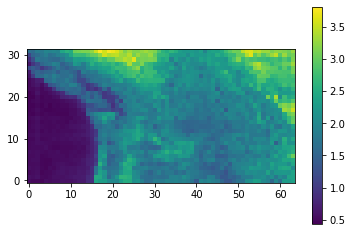

In [78]:
jflvm_pnw_maxt_avg_rmse = np.mean(jflvm_pnw_maxt[:1], axis=0)[0]
plt.imshow(jflvm_pnw_maxt_avg_rmse, origin='lower')
plt.colorbar()